In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [4]:
from underwriting import client_surveillance_jupyter

In [6]:
COMPANY_IDENTIFIER = ['99HT']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [7]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [8]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000279-LIC,Retailer,99 HIGHTIDE COLLECTIVE,True,Active,CA-00095,Retailer,54013296-4d58-48bb-bd1b-a6e7b2d17aa3,bfe0b8b2-15f7-44cc-adce-ea909be06c47


## Check download status summaries

In [9]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [10]:
license_numbers

array(['C10-0000279-LIC'], dtype=object)

In [11]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license C10-0000279-LIC...
Earliest download summary: 2021-01-01
Latest download summary: 2022-04-23
Found bad download summary for license C10-0000279-LIC on date 2022-03-09

[FAILURE] Found a total of 1 bad download summaries


In [12]:
bad_download_history

defaultdict(list, {'C10-0000279-LIC': [datetime.date(2022, 3, 9)]})

## Choose license numbers

In [13]:
# get list of retailer license numbers
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['C10-0000279-LIC']

# License check

In [14]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,CA,C10-0000279-LIC,Retailer,99 HIGHTIDE COLLECTIVE,True,Active,CA-00095,Retailer,54013296-4d58-48bb-bd1b-a6e7b2d17aa3,bfe0b8b2-15f7-44cc-adce-ea909be06c47


In [15]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'CA'

In [16]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]
retial_license_check_df


,license_number,license_category,is_current,license_status,us_state,license_check
0,C10-0000279-LIC,Retailer,True,Active,CA,YES


## Pull data

In [17]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)

company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [18]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['C10-0000279-LIC'], dtype=object)

In [19]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000279-LIC'], dtype=object)

In [20]:
company_inventory_packages_dataframe['license_number'].unique()

array(['C10-0000279-LIC'], dtype=object)

## Unknown transfer packages

In [21]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

## Receiver wholesale price coverage

In [22]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(3957, 32)

In [23]:
company_incoming_transfer_packages_dataframe.shape

(4210, 32)

In [24]:
rwp_coverage = client_surveillance_jupyter.check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


94.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [25]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [26]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [27]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['C10-0000279-LIC'], dtype=object)

## Trxns missing incoming transfer packages

In [28]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = client_surveillance_jupyter.check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 8390 (7.595234646581692%)
# transactions total: 110464


In [29]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2020-05       1
2020-07       1
2020-08       2
2020-10       1
2020-11       7
2020-12     146
2021-01    2262
2021-02     545
2021-03     399
2021-04     242
2021-05     324
2021-06     250
2021-07     256
2021-08     170
2021-09      72
2021-10      34
2021-11      85
2021-12     166
2022-01     280
2022-02     333
2022-03     166
2022-04      83
dtype: int64

## Receipts missing metrc_sales_transactions

In [30]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [31]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 51136


In [32]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

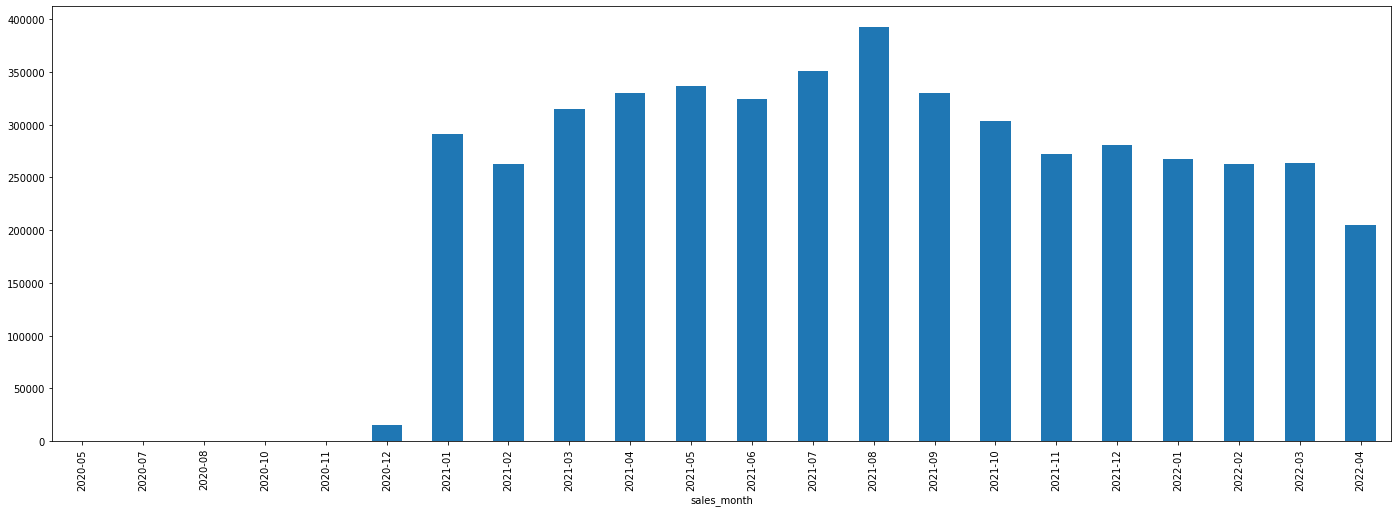

In [33]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# Vendor churn

In [34]:
WINDOW = 4
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-04-01'
VC_MONTH_LIST = ['2022-01-01','2022-02-01','2022-03-01','2022-04-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [35]:
license_numbers

['C10-0000279-LIC']

In [36]:
churn,vc_matrix = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


In [37]:
churn_short,vc_matrix_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


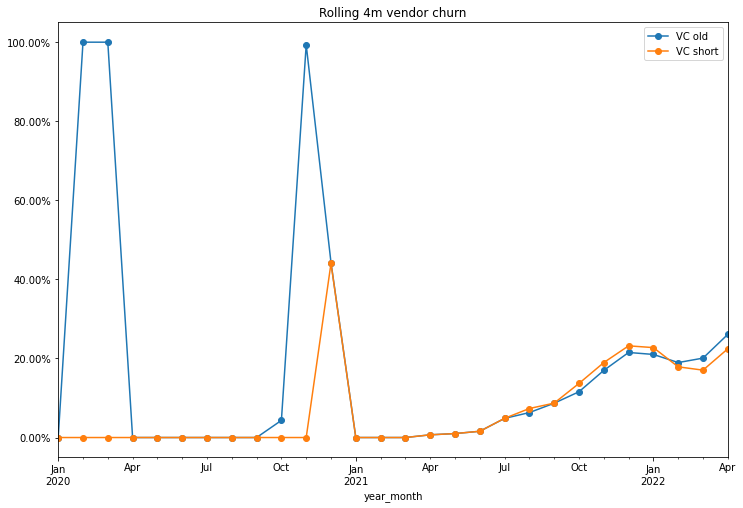

In [38]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [39]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 819.0 from package ID: 14968244
min per unit incoming: 5e-05 from package ID: 11487679



In [40]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,14968244,819.0
1,10878789,350.0
2,23054172,200.0
3,17352701,180.0
4,23054555,100.0
5,16085581,85.0
6,17593036,85.0
7,17762549,85.0
8,16085584,85.0
9,21722057,75.0


In [41]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
4024,14968227,0.000159
4025,11487683,0.000100
4026,11487623,0.000067
4027,11576524,0.000067
4028,11487679,0.000050


In [42]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,receiver_wholesale_price_1,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming


# COGS analysis

In [43]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] <= 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [44]:
df_summary_simp,df_cogs_average_product = client_surveillance_jupyter.cogs_analysis(df_in,df_sales,'monthly',company_state)


In [45]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,291646.25,69820.681173,221825.568827,0.760598,4810.0,2005.0,2805,0.696294,6908,335393.1875,88672.265090,246720.922410,0.735617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735617,NaN,NaN,NaN,NaN
2021-02,2021-02,262906.73,85244.682175,177662.047825,0.675761,5464.0,377.0,5087,0.948611,5760,302342.7395,108260.746362,194081.993138,0.641927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.641927,NaN,NaN,NaN,-0.098542
2021-03,2021-03,315154.72,99796.521792,215358.198208,0.683341,6902.0,159.0,6743,0.951475,7254,362427.9280,126741.582676,235686.345324,0.650299,0.706567,NaN,NaN,254861.885140,0.675948,NaN,NaN,0.650299,0.675948,NaN,NaN,0.198732
2021-04,2021-04,329925.48,100825.215287,229100.264713,0.694400,7081.0,112.0,6969,0.931465,7602,379414.3020,128048.023414,251366.278586,0.662511,0.684501,NaN,NaN,285866.419253,0.651579,NaN,NaN,0.662511,0.651579,NaN,NaN,0.046868
2021-05,2021-05,336793.80,98971.770002,237822.029998,0.706135,7286.0,131.0,7155,0.918326,7934,387312.8700,125694.147903,261618.722097,0.675471,0.694626,NaN,NaN,299593.507081,0.662760,NaN,NaN,0.675471,0.662760,NaN,NaN,0.020818
2021-06,2021-06,324788.69,98014.813307,226773.876693,0.698220,6860.0,114.0,6746,0.926026,7408,373506.9935,124478.812900,249028.180600,0.666730,0.699585,0.703076,NaN,297811.798596,0.668237,0.672092,NaN,0.666730,0.668237,0.672092,NaN,-0.035645
2021-07,2021-07,350888.53,110945.118678,239943.411322,0.683817,7866.0,40.0,7826,0.954843,8238,403521.8095,140900.300722,262621.508778,0.650824,0.696057,0.690279,NaN,307931.701988,0.664341,0.657960,NaN,0.650824,0.664341,0.657960,NaN,0.080359
2021-08,2021-08,392729.34,124638.398749,268090.941251,0.682635,8926.0,22.0,8904,0.974880,9156,451638.7410,158290.766411,293347.974589,0.649519,0.688224,0.691425,NaN,333598.330734,0.655691,0.659226,NaN,0.649519,0.655691,0.659226,NaN,0.119242
2021-09,2021-09,330288.52,116389.637758,213898.882242,0.647612,7341.0,3.0,7338,0.987357,7435,379831.7980,147814.839953,232016.958047,0.610841,0.671355,0.685470,0.692502,351973.155185,0.637061,0.652649,0.660415,0.610841,0.637061,0.652649,0.660415,-0.158992


# Revenue change vs state

In [46]:
a = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp)
round(a.dropna()['total'].sum(),2)

7.8

In [47]:
a

,sum_gmv,sum_gmv_change,sum_gmv_change_ca,weight,variance,points,total
2020Q1,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q2,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q3,0.00,NaN,NaN,NaN,NaN,10,NaN
2020Q4,0.00,NaN,0.17,0.04,NaN,10,0.4
2021Q1,869707.70,NaN,-0.05,0.28,NaN,10,2.8
2021Q2,991507.97,0.140047,0.02,0.52,0.120047,10,5.2
2021Q3,1073906.39,0.083104,-0.11,0.76,0.193104,10,7.6
2021Q4,856300.75,-0.202630,0.00,1.00,-0.202630,-5,-5.0


# Inventory

In [48]:
today = date.today()
today

datetime.date(2022, 5, 5)

In [49]:
COMPANY_IDENTIFIER

['99HT']

In [50]:
license_numbers

['C10-0000279-LIC']

In [51]:
df_inventory_license = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory,license_numbers,today)

In [52]:
df_inventory_license

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-05-05,126426.911773,160562.177951,738,797,0.925972,[C10-0000279-LIC],99 HIGHTIDE COLLECTIVE


In [53]:
df_inventory_license_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales,df_inventory,license_numbers,today)

In [54]:
df_inventory_license_msrp

,date,value,total_incoming,total,coverage,license,legal_name
0,2022-05-05,414733.689922,668,797,0.838143,[C10-0000279-LIC],99 HIGHTIDE COLLECTIVE


In [55]:
current_month = '2022-04'
full_score = 45

# Create Template: updated

In [56]:
license_numbers

['C10-0000279-LIC']

In [57]:
template_new_ = client_surveillance_jupyter.create_template_new(a,df_summary_simp,df_inventory_license,df_inventory_license_msrp,churn_short,retial_license_check_df,license_numbers,company_state,current_month)



0.9418665718948696 True
0.9259723964868256 True
7.252873292334507 10
0.22439021484060578 0


In [58]:
template_new_

,0,1
0,legal name,99 HIGHTIDE COLLECTIVE
1,date,2022-04
2,license,[C10-0000279-LIC]
3,license is current,True
4,license is active,Active
5,license check,YES
6,metrc cogs coverage,0.941867
7,metrc cogs coverage reliable ?,True
8,metrc inventory coverage,0.925972
9,metrc inventory coverage reliable ?,True


# Output data 

In [ ]:
license_numbers

## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



# Appendix

In [1]:
# def calculate_quarterly_sum_gmv_ma_short(cogs_analysis_df):

#     gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
#     gmv_df['sum_gmv_change_ma'] = [-0.07,0.09,-0.11,0.02]
#     gmv_df['weight'] = [0.76,0.84,0.92,1]
#     gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
#     gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
#     gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
#     gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
#     return gmv_df
    